In [1]:
import torch
from NLPUtils import *

import nltk
nltk.download('brown', download_dir='/home/lestien/anaconda3/envs/TorchEnv/nltk_data')
from nltk.corpus import brown

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package brown to
[nltk_data]     /home/lestien/anaconda3/envs/TorchEnv/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Defino las muestras a utilizar para entrenamiento

In [2]:
from torch.utils.data import Dataset

class BrownDataset(Dataset):
    
    def __init__(self, df):
        self.data = df
        self.categories = ['adventure', 'belles_lettres', 'editorial', 'fiction', 
                           'government', 'hobbies', 'humor', 'learned', 'lore', 
                           'mystery', 'news', 'religion', 'reviews', 'romance', 
                           'science_fiction']
        
        # Obtengo el vocabulario a partir del corpus ya tokenizado:
        self.vocabulary = Vocabulary()
        for sentence in self.data['sentence']:
            for token in sentence:
                self.vocabulary.add_token(token)
                
        self.padding_idx = len(self.vocabulary)
        self.longest_sentence_size = self.data['sentence'].str.len().max()
        
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        sentence_vector = torch.ones(self.longest_sentence_size, dtype=torch.long) * self.padding_idx
        for i, token in enumerate(self.data['sentence'].iloc[idx]):
            sentence_vector[i] = self.vocabulary.token_to_index(token)
            
        return sentence_vector, torch.tensor(self.data['label'].iloc[idx],dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    @classmethod
    def get_dataset(cls):
        train_dataframe = pd.read_csv('train.csv')
        train_dataframe = pd.DataFrame({'sentence':train_dataframe['sentence'].str.split('<SEP>'),
                                        'label':train_dataframe['label']})
        test_dataframe = pd.read_csv('test.csv')
        test_dataframe = pd.DataFrame({'sentence':test_dataframe['sentence'].str.split('<SEP>'),
                                       'label':test_dataframe['label']})
        
        return cls(train_dataframe), cls(test_dataframe)

    
def generate_data_batches(train_dataset, test_dataset, # Train y test datasets
                          batch_size = 64, # Tamaño del batch
                          val_size = .02): # Proporción de muestras utilizadas para validación 
    
    """
    Función para iterar sobre los batches de muestras. 
    Devuelve los dataloaders de train / validation / test.
    """

    # Separo las muestras aleatoriamente en Train y Validation:
    NUM_TRAIN = int((1 - val_size) * len(train_dataset)) 
    samples_idx = torch.randperm(len(train_dataset))
    train_samples_idx = samples_idx[:NUM_TRAIN]
    val_samples_idx = samples_idx[NUM_TRAIN:]
    my_sampler = lambda indices: sampler.SubsetRandomSampler(indices) # sampler
    
    # Dataloader para las muestras de entrenamiento:
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, 
                                  sampler=my_sampler(train_samples_idx))

    # Dataloader para las muestras de validación:
    val_dataloader = DataLoader(train_dataset, 
                                batch_size=batch_size, 
                                sampler=my_sampler(val_samples_idx))

    # Dataloader para las muestras de testeo:
    test_dataloader = DataLoader(test_dataset, 
                                 batch_size=batch_size)
    
    return train_dataloader, val_dataloader, test_dataloader

class ClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, num_categories):
        super(ClassificationModel,self).__init__()
        self.emb = nn.Embedding(vocab_size+1, embedding_dim, padding_idx=vocab_size)
        self.out = nn.Linear(embedding_dim, num_categories)
        
    def forward(self,x):
        embedding = self.emb(x).mean(dim=1)
        return self.out(embedding)
    
    def loss(self,scores,target):
        lf = nn.CrossEntropyLoss()
        return lf(scores,target)
    

batch_size = 512
val_size = .1
train_dataset, test_dataset = BrownDataset.get_dataset()
train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset,test_dataset,batch_size=batch_size,val_size=val_size)

corpus = list(train_dataset.data['sentence'])

Se entrenan los word embeddings con las frases del set de entrenamiento

Starting training...
	Model used: SkipGram
    	Optimization method: Stochastic Gradient Descent
    	Learning Rate: 0.01
    	Number of epochs: 200
    	Number of batches: 7561
    	Number of samples per batch: 128

Epoch: 1, Batch number: 0, Loss: 10.96286678314209
Epoch: 1, Batch number: 1000, Loss: 10.750284194946289
Epoch: 1, Batch number: 2000, Loss: 10.733335494995117
Epoch: 1, Batch number: 3000, Loss: 10.649908065795898
Epoch: 1, Batch number: 4000, Loss: 10.579466819763184
Epoch: 1, Batch number: 5000, Loss: 10.501948356628418
Epoch: 1, Batch number: 6000, Loss: 10.616667747497559
Epoch: 1, Batch number: 7000, Loss: 10.380101203918457
Epoch: 2, Batch number: 439, Loss: 10.419939041137695
Epoch: 2, Batch number: 1439, Loss: 10.310420989990234
Epoch: 2, Batch number: 2439, Loss: 10.184311866760254
Epoch: 2, Batch number: 3439, Loss: 10.467259407043457
Epoch: 2, Batch number: 4439, Loss: 10.391796112060547
Epoch: 2, Batch number: 5439, Loss: 10.461066246032715
Epoch: 2, Batch nu

Epoch: 20, Batch number: 3341, Loss: 8.793075561523438
Epoch: 20, Batch number: 4341, Loss: 9.313361167907715
Epoch: 20, Batch number: 5341, Loss: 9.399293899536133
Epoch: 20, Batch number: 6341, Loss: 9.44048023223877
Epoch: 20, Batch number: 7341, Loss: 9.108884811401367
Epoch: 21, Batch number: 780, Loss: 9.255660057067871
Epoch: 21, Batch number: 1780, Loss: 9.07822036743164
Epoch: 21, Batch number: 2780, Loss: 8.733949661254883
Epoch: 21, Batch number: 3780, Loss: 9.067955017089844
Epoch: 21, Batch number: 4780, Loss: 8.93308162689209
Epoch: 21, Batch number: 5780, Loss: 9.354043006896973
Epoch: 21, Batch number: 6780, Loss: 8.976069450378418
Epoch: 22, Batch number: 219, Loss: 9.29457950592041
Epoch: 22, Batch number: 1219, Loss: 9.079675674438477
Epoch: 22, Batch number: 2219, Loss: 9.191619873046875
Epoch: 22, Batch number: 3219, Loss: 9.280989646911621
Epoch: 22, Batch number: 4219, Loss: 8.985549926757812
Epoch: 22, Batch number: 5219, Loss: 8.643571853637695
Epoch: 22, Batch

Epoch: 40, Batch number: 2121, Loss: 7.947116374969482
Epoch: 40, Batch number: 3121, Loss: 8.566088676452637
Epoch: 40, Batch number: 4121, Loss: 8.677268028259277
Epoch: 40, Batch number: 5121, Loss: 8.6398344039917
Epoch: 40, Batch number: 6121, Loss: 8.885927200317383
Epoch: 40, Batch number: 7121, Loss: 8.550487518310547
Epoch: 41, Batch number: 560, Loss: 8.3608980178833
Epoch: 41, Batch number: 1560, Loss: 8.448650360107422
Epoch: 41, Batch number: 2560, Loss: 8.66411018371582
Epoch: 41, Batch number: 3560, Loss: 8.50342845916748
Epoch: 41, Batch number: 4560, Loss: 8.205609321594238
Epoch: 41, Batch number: 5560, Loss: 8.597376823425293
Epoch: 41, Batch number: 6560, Loss: 8.72692584991455
Epoch: 41, Batch number: 7560, Loss: 8.957121849060059
Epoch: 42, Batch number: 999, Loss: 8.377318382263184
Epoch: 42, Batch number: 1999, Loss: 8.4973783493042
Epoch: 42, Batch number: 2999, Loss: 8.508661270141602
Epoch: 42, Batch number: 3999, Loss: 8.596786499023438
Epoch: 42, Batch numb

Epoch: 60, Batch number: 1901, Loss: 8.523353576660156
Epoch: 60, Batch number: 2901, Loss: 8.291088104248047
Epoch: 60, Batch number: 3901, Loss: 8.01569652557373
Epoch: 60, Batch number: 4901, Loss: 8.493988037109375
Epoch: 60, Batch number: 5901, Loss: 8.380263328552246
Epoch: 60, Batch number: 6901, Loss: 8.229045867919922
Epoch: 61, Batch number: 340, Loss: 8.522344589233398
Epoch: 61, Batch number: 1340, Loss: 8.287428855895996
Epoch: 61, Batch number: 2340, Loss: 8.304715156555176
Epoch: 61, Batch number: 3340, Loss: 8.410064697265625
Epoch: 61, Batch number: 4340, Loss: 8.080059051513672
Epoch: 61, Batch number: 5340, Loss: 7.941041946411133
Epoch: 61, Batch number: 6340, Loss: 8.542115211486816
Epoch: 61, Batch number: 7340, Loss: 8.464703559875488
Epoch: 62, Batch number: 779, Loss: 8.316802978515625
Epoch: 62, Batch number: 1779, Loss: 8.030516624450684
Epoch: 62, Batch number: 2779, Loss: 8.298728942871094
Epoch: 62, Batch number: 3779, Loss: 7.956762313842773
Epoch: 62, Ba

Exiting training...



<IPython.core.display.Javascript object>


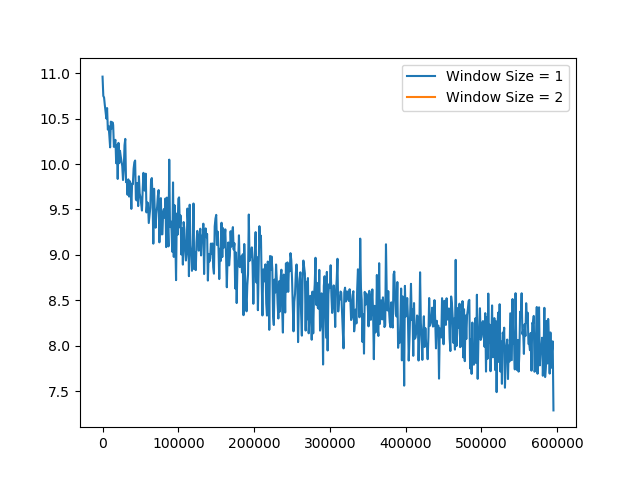

In [3]:
# Modelo de lenguaje:
method = 'SkipGram'
window_size = [1,2]
embedding_dim = 100
pretrained = None

# Parámetros de iteración:
batch_size = 128
epochs = 200
learning_rate = 1e-2
sample_loss_every = 1000
use_gpu = 0

history = []
embeddings_vs_windows = []

for ws in window_size:
    embedding_layer, vocab, loss_history = SGDTrainWordVectors(corpus,pretrained_layer=pretrained,lm=method,window_size=ws,batch_size=batch_size,embedding_dim=embedding_dim,use_gpu=use_gpu,epochs=epochs,learning_rate=learning_rate,sample_loss_every=sample_loss_every)
    embeddings_vs_windows.append(embedding_layer)
    history.append(loss_history)
    
fig, ax = plt.subplots()
for i, ws in enumerate(window_size):
    ax.plot(history[i]['iter'],history[i]['loss'],label='Window Size = {}'.format(ws))

ax.legend()

Se entrena el modelo de clasificación

Training for window size = 1
Epoch: 1, Batch number: 0
Accuracy on validation dataset: 324/4778 (6.78%)
Epoch: 3, Batch number: 16
Accuracy on validation dataset: 443/4778 (9.27%)
Epoch: 5, Batch number: 32
Accuracy on validation dataset: 536/4778 (11.22%)
Epoch: 8, Batch number: 6
Accuracy on validation dataset: 604/4778 (12.64%)
Epoch: 10, Batch number: 22
Accuracy on validation dataset: 636/4778 (13.31%)
Epoch: 12, Batch number: 38
Accuracy on validation dataset: 651/4778 (13.62%)
Epoch: 15, Batch number: 12
Accuracy on validation dataset: 653/4778 (13.67%)
Epoch: 17, Batch number: 28
Accuracy on validation dataset: 655/4778 (13.71%)
Epoch: 20, Batch number: 2
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 22, Batch number: 18
Accuracy on validation dataset: 658/4778 (13.77%)
Epoch: 24, Batch number: 34
Accuracy on validation dataset: 658/4778 (13.77%)
Epoch: 27, Batch number: 8
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 29, Batch number: 24
Accuracy on valid

Epoch: 29, Batch number: 24
Accuracy on validation dataset: 510/4778 (10.67%)
Epoch: 31, Batch number: 40
Accuracy on validation dataset: 567/4778 (11.87%)
Epoch: 34, Batch number: 14
Accuracy on validation dataset: 594/4778 (12.43%)
Epoch: 36, Batch number: 30
Accuracy on validation dataset: 620/4778 (12.98%)
Epoch: 39, Batch number: 4
Accuracy on validation dataset: 633/4778 (13.25%)
Epoch: 41, Batch number: 20
Accuracy on validation dataset: 642/4778 (13.44%)
Epoch: 43, Batch number: 36
Accuracy on validation dataset: 643/4778 (13.46%)
Epoch: 46, Batch number: 10
Accuracy on validation dataset: 649/4778 (13.58%)
Epoch: 48, Batch number: 26
Accuracy on validation dataset: 649/4778 (13.58%)
Epoch: 51, Batch number: 0
Accuracy on validation dataset: 652/4778 (13.65%)
Epoch: 53, Batch number: 16
Accuracy on validation dataset: 654/4778 (13.69%)
Epoch: 55, Batch number: 32
Accuracy on validation dataset: 662/4778 (13.86%)
Epoch: 58, Batch number: 6
Accuracy on validation dataset: 668/477

Epoch: 279, Batch number: 24
Accuracy on validation dataset: 658/4778 (13.77%)
Epoch: 281, Batch number: 40
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 284, Batch number: 14
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 286, Batch number: 30
Accuracy on validation dataset: 658/4778 (13.77%)
Epoch: 289, Batch number: 4
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 291, Batch number: 20
Accuracy on validation dataset: 655/4778 (13.71%)
Epoch: 293, Batch number: 36
Accuracy on validation dataset: 655/4778 (13.71%)
Epoch: 296, Batch number: 10
Accuracy on validation dataset: 656/4778 (13.73%)
Epoch: 298, Batch number: 26
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 301, Batch number: 0
Accuracy on validation dataset: 657/4778 (13.75%)
Epoch: 303, Batch number: 16
Accuracy on validation dataset: 656/4778 (13.73%)
Epoch: 305, Batch number: 32
Accuracy on validation dataset: 655/4778 (13.71%)
Epoch: 308, Batch number: 6
Accuracy on validation dat

Epoch: 139, Batch number: 4
Accuracy on validation dataset: 647/4778 (13.54%)
Epoch: 141, Batch number: 20
Accuracy on validation dataset: 646/4778 (13.52%)
Epoch: 143, Batch number: 36
Accuracy on validation dataset: 650/4778 (13.60%)
Epoch: 146, Batch number: 10
Accuracy on validation dataset: 658/4778 (13.77%)
Epoch: 148, Batch number: 26
Accuracy on validation dataset: 660/4778 (13.81%)
Epoch: 151, Batch number: 0
Accuracy on validation dataset: 656/4778 (13.73%)
Epoch: 153, Batch number: 16
Accuracy on validation dataset: 652/4778 (13.65%)
Epoch: 155, Batch number: 32
Accuracy on validation dataset: 654/4778 (13.69%)
Epoch: 158, Batch number: 6
Accuracy on validation dataset: 662/4778 (13.86%)
Epoch: 160, Batch number: 22
Accuracy on validation dataset: 670/4778 (14.02%)
Epoch: 162, Batch number: 38
Accuracy on validation dataset: 673/4778 (14.09%)
Epoch: 165, Batch number: 12
Accuracy on validation dataset: 673/4778 (14.09%)
Epoch: 167, Batch number: 28
Accuracy on validation dat

Epoch: 389, Batch number: 4
Accuracy on validation dataset: 667/4778 (13.96%)
Epoch: 391, Batch number: 20
Accuracy on validation dataset: 667/4778 (13.96%)
Epoch: 393, Batch number: 36
Accuracy on validation dataset: 666/4778 (13.94%)
Epoch: 396, Batch number: 10
Accuracy on validation dataset: 666/4778 (13.94%)
Epoch: 398, Batch number: 26
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 401, Batch number: 0
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 403, Batch number: 16
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 405, Batch number: 32
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 408, Batch number: 6
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 410, Batch number: 22
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 412, Batch number: 38
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 415, Batch number: 12
Accuracy on validation dataset: 665/4778 (13.92%)
Epoch: 417, Batch number: 28
Accuracy on validation dat

<IPython.core.display.Javascript object>


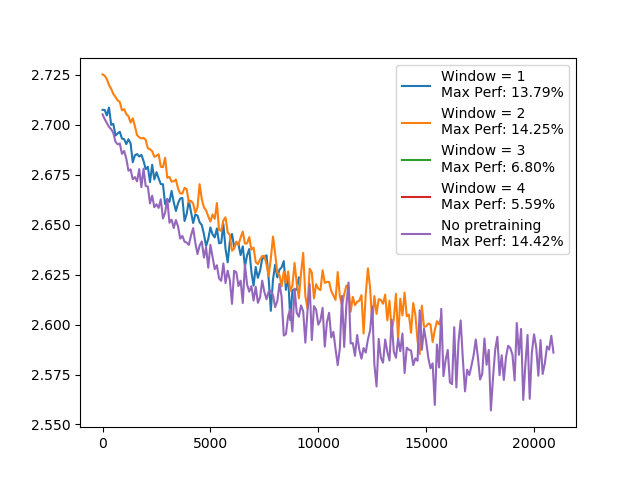

In [4]:
# Parámetros del modelo:
vocab_size = len(train_dataset.vocabulary)
num_categories = len(brown.categories())

# Parámetros del entrenamiento:
epochs = 500
learning_rate = 1e-3
sample_loss_every = 100
check_on_train = False
use_gpu = 1

# Diccionario de datos:
train_data = {'train': train_dataloader,
              'validation': val_dataloader}

performance_history = []
for ws, embedding_layer in zip(window_size,embeddings_vs_windows):
    print('Training for window size = {}'.format(ws))
    model = ClassificationModel(vocab_size, embedding_dim, num_categories)
    model.emb.load_state_dict(embedding_layer.state_dict())
    for param in model.emb.parameters():
        param.requires_grad = False
    ph = SGDTrainModel(model,train_data,epochs=epochs,learning_rate=learning_rate,sample_loss_every=sample_loss_every,check_on_train=check_on_train,use_gpu=use_gpu)
    performance_history.append(ph)
    print()

print('Training with no embeddings')
model = ClassificationModel(vocab_size, embedding_dim, num_categories)
ph = SGDTrainModel(model,train_data,epochs=epochs,learning_rate=learning_rate,sample_loss_every=sample_loss_every,check_on_train=check_on_train,use_gpu=use_gpu)
performance_history.append(ph)
    
fig, ax = plt.subplots()
for i, ws in enumerate(window_size):
    ax.plot(performance_history[i]['iter'],performance_history[i]['loss'], 
            label="Window = {}\nMax Perf: {:.2f}%".format(ws,max(performance_history[i]['accuracy'])*100))
ax.plot(performance_history[-1]['iter'],performance_history[-1]['loss'], 
        label="No pretraining\nMax Perf: {:.2f}%".format(max(performance_history[-1]['accuracy'])*100))

ax.legend()